In [1]:
import gc

# data
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# encoders
from tools.encoders import LabelEncoder
from tools.encoders import FrequencyEncoder
from tools.encoders import AggregateEncoder

# model
import xgboost as xgb

# evaluation
from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score


In [2]:
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode


In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50000)

In [4]:
# load dataset - full
# train_tr = pd.read_csv("data/train_transaction.csv")
# test_tr  = pd.read_csv("data/test_transaction.csv")
# train_id = pd.read_csv("data/train_identity.csv")
# test_id  = pd.read_csv("data/test_identity.csv")

# load dataset - partial (for testing)
train_tr = pd.read_csv("D:\DATA KAGGLE\IEEE CIS FRAUD DETECTION\\train_transaction.csv",nrows=50000)
test_tr  = pd.read_csv("D:\DATA KAGGLE\IEEE CIS FRAUD DETECTION\\test_transaction.csv",nrows=50000)
train_id = pd.read_csv("D:\DATA KAGGLE\IEEE CIS FRAUD DETECTION\\train_identity.csv",nrows=50000)
test_id  = pd.read_csv("D:\DATA KAGGLE\IEEE CIS FRAUD DETECTION\\test_identity.csv",nrows=50000)

# , nrows=50000

In [5]:
# try to merge the transaction and identity dataframes
try:
    train = pd.merge(train_tr, train_id, on="TransactionID", how="left")
    test  = pd.merge( test_tr,  test_id, on="TransactionID", how="left")

    del train_tr, train_id, test_tr, test_id
    x = gc.collect()
    
except Exception:
    pass

train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0

In [10]:
train = train.drop(columns=['TransactionID'], errors="ignore")
test  =  test.drop(columns=['TransactionID'], errors="ignore")

In [7]:
# the columns in test dataset have different naming
test.columns = [col.replace('-', '_') for col in test.columns]

In [8]:
# the original columns not to be removed
orig_cols = ["TransactionID", "isFraud", "TransactionDT", "TransactionAmt", "ProductCD",
             "card1", "card2", "card3", "card4", "card5", "card6", "addr1", "addr2", "dist1", "dist2",
             "C1", "C2", "C3", "C4", "C5", "C6", "C7", "C8", "C9", "C10", "C11", "C12", "C13", "C14",
             "D1", "D2", "D3", "D4", "D5", "D6", "D7", "D8", "D9", "D10", "D11", "D12", "D13", "D14", "D15", 
             "M1", "M2", "M3", "M4", "M5", "M6", "M7", "M8", "M9", "P_emaildomain", "R_emaildomain"]

### <span style="color:teal">One Value Columns</span>

* The columns with only one unique value are dropped
* The columns with 90% of missing data are dropped
* The columns with only one value spanning 90% data are also dropped

In [9]:
# finding cols with only one unique value
one_val_cols = [col for col in train.columns if train[col].nunique() <= 1]
one_val_test = [col for col in  test.columns if  test[col].nunique() <= 1]

# finding cols with more than 90% missing data
missing_cols = [col for col in train.columns if train[col].isnull().sum() / train.shape[0] > 0.9]
missing_test = [col for col in  test.columns if  test[col].isnull().sum() /  test.shape[0] > 0.9]

# finding cols with 90% of data covered by one unique value
skewed_cols = [col for col in train.columns if train[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]
skewed_test = [col for col in  test.columns if  test[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]

In [10]:
# combine all the above to get a list of all columns
cols_to_drop = list(set(one_val_cols + missing_cols + skewed_cols +
                        one_val_test + missing_test + skewed_test))

# not removing original columns
cols_to_drop = [col for col in cols_to_drop if col not in orig_cols]

In [11]:
print("Number of columns to be dropped : %d" % len(set(cols_to_drop) & set(train.columns)))

Number of columns to be dropped : 128


In [12]:
# drop the columns
train = train.drop(cols_to_drop, axis=1, errors="ignore")
test  =  test.drop(cols_to_drop, axis=1, errors="ignore")

print("Number of remaining columns : %d" % len(train.columns))

Number of remaining columns : 306


## <span style="color:teal">NaN structure</span>

We decide which columns are possibly dependent by looking at their NaN structure. <br>
If the counts are equal, we assume they are similar and group them together. <br>
Judging by the number of groups, the V columns that have been grouped might be constructed from the similar subset of columns <br>

1. structure of D1 corresponds to that of a subset of V281 - V315.
2. structure of D11 corresponds to V1 - V11.
3. Also we find groups of V-columns with similar NaN counts

In [13]:
# list to store nan structured groups
na_group_list = []

# temp vars
nan_df = train.isna()
nan_groups={}

# iterate and cluster na structure
for col in train.columns:
    cur_group = nan_df[col].sum()
    
    try:
        nan_groups[cur_group].append(col)  # Here we are storing it as dict such that all same no of nans are together
    except Exception:
        nan_groups[cur_group]=[col]

for key, val in nan_groups.items():
    print("\033[34;1m------- NaN count : %d ---------\033[0m" % key)
    print(val, end="\n\n")
    
    # only append 'V' columns
    v_list = [col for col in val if col[0] == "V"]
    if v_list:
        na_group_list.append(v_list)

del nan_df, nan_groups
x = gc.collect()

------- NaN count : 0 ---------
['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt', 'ProductCD', 'card1', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'V95', 'V96', 'V97', 'V99', 'V100', 'V126', 'V127', 'V128', 'V130', 'V131', 'V282', 'V283', 'V288', 'V289', 'V313', 'V314', 'V315']

------- NaN count : 697 ---------
['card2']

------- NaN count : 3 ---------
['card3', 'card6']

------- NaN count : 6 ---------
['card4']

------- NaN count : 235 ---------
['card5']

------- NaN count : 2591 ---------
['addr1', 'addr2']

------- NaN count : 33120 ---------
['dist1']

------- NaN count : 46645 ---------
['dist2']

------- NaN count : 8986 ---------
['P_emaildomain']

------- NaN count : 38340 ---------
['R_emaildomain']

------- NaN count : 26516 ---------
['D2']

------- NaN count : 25556 ---------
['D3']

------- NaN count : 23171 ---------
['D4']

------- NaN count : 32179 ---------
['D5']

------- NaN count : 45175 ---------

## <span style="color:teal">Redundant V Columns</span>

Steps to reduce collinear columns

1. Correlation matrix is obtained
2. Only such pairs are chosen, whose correlation exceeds a certain value. (0.8)
3. The column with least unique values is dropped so that least information is lost
4. This is continued until there are no column pairs with high enough correlation

In [18]:
def redundant_columns(dataframe, cols, thresh=0.8):
    # Find columns to be dropped which have high correlations
    # PARAMETERS -----------------------
    # dataframe    dataframe to scan
    # cols         columns of df to focus
    # thresh       min correlation to drop
    # RETURNS --------------------------
    # list of droppable column names
    
    # no cols specified
    if not cols:
        return []
    
    col_pair = []
    col_drop = []
    
    cols     = list(set(cols) & set(dataframe.columns))
    nunique  = {col : dataframe[col].nunique() for col in cols}
    corr_mat = dataframe[cols].corr()
    
    # find higher values in corr_matrix
    for i, col in enumerate(cols):
        for j in range(i):
            if corr_mat[col][j] >= thresh:
                col_pair.append((col, cols[j]))
    
    
    # iterate until the list gets exhausted
    while col_pair:
        
        # first pass : find least unique value column
        rem_val = len(dataframe)
        rem_col = ''
        
        for c1, c2 in col_pair:
            if nunique[c1] < rem_val:
                rem_val = nunique[c1]
                rem_col = c1
            if nunique[c2] < rem_val:
                rem_val = nunique[c2]
                rem_col = c2
        
        # second pass : remove tuples containing rem_col
        new_pair = []
        
        for c1, c2 in col_pair:
            if c1 != rem_col and c2 != rem_col:
                new_pair.append((c1, c2))
        
        # update
        col_drop.append(rem_col)
        col_pair = new_pair
    
    return col_drop

In [19]:
# obtain list of droppable columns
all_drop_cols = set()
corr_threshold = 0.8

for sublist in na_group_list:
    
    # obtain redundant columns from sublist
    
    drop_cols = redundant_columns(train, cols=sublist, thresh=corr_threshold)

    # update dropping columns
    all_drop_cols = all_drop_cols | set(drop_cols)

# print number of dropping cols
print("Number of columns to be dropped : %d" % len(all_drop_cols))

Number of columns to be dropped : 134


In [20]:
# drop
train = train.drop(columns=all_drop_cols, errors="ignore")
test  =  test.drop(columns=all_drop_cols, errors="ignore")

print("Number of remaining columns : %d" % len(train.columns))

Number of remaining columns : 171


In [94]:
train1 = train
test1 = test

In [79]:
train = train1
test = test1

## <span style="color:teal">Time consistency</span>

From EDA, it is found that test and train datasets are separated by time.
We will now check each of the columns for "time consistency". We will build models such that each model will be trained on the first month of the training data and will only use one feature. We will then predict the last month of the training data. We want both training AUC and validation AUC to be above 0.5

In [95]:
# TransactionDT is useless for training
# some D columns have too much missing values
drop_cols = ["D6", "D7", "D8", "D12", "D13", "D14"]

train.drop(columns=drop_cols, inplace=True, errors="ignore")
test. drop(columns=drop_cols, inplace=True, errors="ignore")

print(len(train.columns))

162


In [96]:
# Failed Time consistency test
drop_cols = ["card4", "C3", "M5", "id_07", "id_08", "id_14", "id_21", "id_30", "id_32", "id_33", "id_34"]
drop_cols.extend(["id_" + str(x) for x in range(22,28)])

train.drop(columns=drop_cols, inplace=True, errors="ignore")
test. drop(columns=drop_cols, inplace=True, errors="ignore")

print(len(train.columns))

162


## <span style="color:teal">Transformation</span>

1. __TransactionCent__ : Obtained from TransactionAmt, which contains just the cents in the amount.
2. __D_columns__ : Subtracted by TransactionDT with appropriate scaling factor.


In [97]:
# TransactionCent
train["TransactionCent"] = train["TransactionAmt"] - np.floor(train["TransactionAmt"])
test ["TransactionCent"] =  test["TransactionAmt"] - np.floor( test["TransactionAmt"])

The D columns are time deltas from an unknown date.<br>
Normalization is done by subtracting TransactionDT with appropriate scaling factor <br>
TransactionDT is in seconds, and D columns are in days. <br>
`days = seconds / 60 * 60 * 24`

D4, D6, D7, D8, D10, D11, D12, D13, D14, D15 increase with time, and have to be normalized.

In [98]:
# D_columns
for col in [4, 6, 7, 8, 10, 11, 12, 13, 14, 15]:
    colname = "D" + str(col)
    
    try:
        # transform
        train[colname] = train[colname] - train["TransactionDT"] / float(86400)
        test [colname] =  test[colname] -  test["TransactionDT"] / float(86400)
        
        # rename columns to avoid transformation again
        train = train.rename(columns={colname : colname + "n"})
        test  =  test.rename(columns={colname : colname + "n"})
    
    except Exception:
        pass

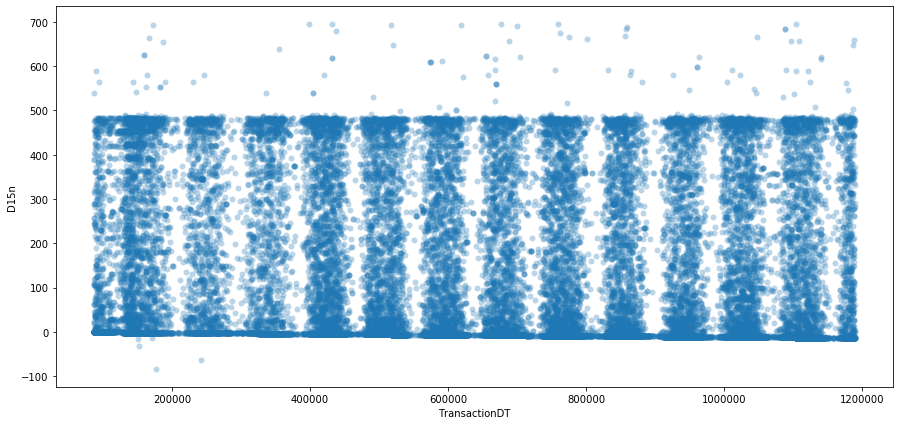

In [26]:
# the transformed D15 column
plt.figure(figsize=(15, 7))
ax = sns.scatterplot(train["TransactionDT"], train["D15n"], alpha=0.3, linewidth=0)

In [ ]:

train.to_csv('IEEE_cftrain.csv',index = False)
test.to_csv('IEEE_cftest.csv',index = False)

## <span style="color:teal">Missing Values - Categorical</span>

For encoding successfully, without ambiguity, missing values are filled with a new category, "NaN" which mimics a non-null category. This is useful for both grouping by category and other such operations.<br>
Most of categorical columns are found by their datatypes, namely object, and missing values are filled using `df.fillna()` method.<br>

In [99]:
# find categorical columns
cat_cols = list(train.dtypes[train.dtypes==object].index)
cat_cols.sort()
print(cat_cols)

[]


In [100]:
# fill values with NaN
train[cat_cols] = train[cat_cols].fillna("NaN")
test [cat_cols] =  test[cat_cols].fillna("NaN")

## <span style="color:teal">Combining</span>

1. __card1_addr1__ : Obtained by concatenating card1 and addr1
2. __card1_addr1_pemail__ : Obtained by concatenating card1_addr1 and P_emaildomain

In [ ]:
# card1_addr1
train["card1_addr1"] = train["card1"].astype(str) + "_" + train["addr1"].astype(str)
test ["card1_addr1"] =  test["card1"].astype(str) + "_" +  test["addr1"].astype(str)

# card1_addr1_P_emaildomain
train["card1_addr1_pemail"] = train["card1_addr1"].astype(str) + "_" + train["P_emaildomain"].astype(str)
test ["card1_addr1_pemail"] =  test["card1_addr1"].astype(str) + "_" +  test["P_emaildomain"].astype(str)

## <span style="color:teal">Encoding</span>

Various types of encoding is done so that model has knowledge of group aggregates and other such properties of a variable at every instant.<br>

Three types of encodings are used :
1. __Frequency Encoding__
3. __Aggregate Encoding__
2. __Label Encoding__

### <span style="color:darkslateblue">Frequency Encode</span>

Add a new column with the frequency of each category (number of times it appears in the data).<br>
Frequency of categories in training is used to encode the test categories.<br>
If a new category is found in test, it is alloted a frequency of 0.

In [195]:
cols = ["addr1", "card1", "card2", "card3", "card1_addr1", "card1_addr1_pemail", "P_emaildomain"]

# fit and transform
frqenc = FrequencyEncoder()
train = frqenc.fit_transform(train, cols)
test  = frqenc.transform(test, cols)

del cols

KeyError: 'card1_addr1'

### <span style="color:darkslateblue">Aggregate Encode</span>

Add a new column with aggregates of the column grouped by uids.<br>
The pairs are chosen so that the validation is maximum.

In [ ]:
cols = ["TransactionAmt", "D9", "D11n"]
uids = ["card1","card1_addr1","card1_addr1_pemail"]

In [ ]:
# fit and transform - mean
meanenc = AggregateEncoder(aggr_type="mean", fillna=-1)
train = meanenc.fit_transform(train, cols, uids)
test  = meanenc.transform(test, cols, uids)

In [ ]:
# fit and transform - std
stdenc = AggregateEncoder(aggr_type="std", fillna=-1)
train = stdenc.fit_transform(train, cols, uids)
test  = stdenc.transform(test, cols, uids)

In [ ]:
del cols, uids

### <span style="color:darkslateblue">Label Encode</span>

Add a new column with a unique number for each category.<br>
The ids of categories in training is used to encode the test categories.<br>
If there is a new category in test, label is set to 0.

In [101]:
cols = list(train.dtypes[train.dtypes==object].index)
cols.sort()

# fit and transform
lblenc = LabelEncoder(drop_original=True)
train = lblenc.fit_transform(train, cols)
test  = lblenc.transform(test, cols)

del cols

## <span style="color:teal">Missing Values - Quantitative</span>

This is done just to represent missing values in these columns. -128 is the least number for int8 numbers, so it is preferable for substitution. This is also preferable for reducing memory, since columns with missing values are forced to be float type.<br>
It is also important for no other valid number to be equal to NaN substitute.

In [81]:
print((train == -127).sum().sum())
print((test  == -127).sum().sum())

0
0


In [102]:
train.fillna(-127, inplace=True)
test. fillna(-127, inplace=True)

In [103]:
# 2nd method of filling with mode for algos which dont deal with missing values

train.fillna(train.mean(), inplace=True)
test. fillna(test.mean(), inplace=True)

## <span style="color:teal">Reducing Memory</span>

From the distribution of datatypes, we see a lot of float64 datatypes as well as int64. However, most of the columns have much smaller ranges. So, we can reduce the sizes of the columns, so that the dataset is light on memory as well as computation.

#####  memory_usage func

index  -  bool, default True
Specifies whether to include the memory usage of the DataFrame’s index in returned Series. If index=True, the memory usage of the index is the first item in the output.


deep - If True, introspect the data deeply by interrogating object dtypes for system-level memory consumption, and include it in the returned values.


Returns
Series
A Series whose index is the original column names and whose values is the memory usage of each column in bytes.

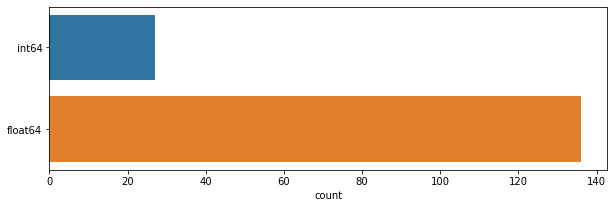

In [60]:
# plot dtype distribution
fig = plt.figure(figsize=(10, 3))
ax = sns.countplot(y=train.dtypes.astype(str))

# previous usage
tr_mem = train.memory_usage(deep=True).sum() / (1024*1024)   # deep will anals
ts_mem = test .memory_usage(deep=True).sum() / (1024*1024)

In [61]:
for col in test.columns:
    
    d1 = str(train[col].dtype)
    d2 = str( test[col].dtype)
    
    dt = d1
    
    # ignore if object found
    if "object" in d1 + d2:
        continue
    
    # get the best of both datatypes; that is capture the max memory to prevent loss of info
    if d1 != d2:
        
        cd1 = "float" in d1
        cd2 = "float" in d2

        if cd1 and not cd2:
            dt = d1
        elif cd2 and not cd1:
            dt = d2
        else:
            dt = max(d1, d2)
            
        
    # if dtype is float, check if it actually needs it
    if "float" in dt and train[col].isna().sum() + test[col].isna().sum() == 0:
        sa = abs(train[col] - train[col].astype(np.int64))
        sb = abs( test[col] -  test[col].astype(np.int64))
        
        # decimal values are not very small
        l1 = sa.between(2**-11, 1 - 2**-11).sum()
        l2 = sb.between(2**-11, 1 - 2**-11).sum()
                
        # if there are none, convert to int
        if max(l1, l2) == 0:
            dt = "int64"
    
    # find max absolute value
    ma = max(abs(train[col].max()), abs(test[col].max()))
    mb = max(abs(train[col].min()), abs(test[col].min()))
    mx = max(ma, mb)
    
    # int shrink
    if "int" in dt:
        if   mx < 2**7:  dn = np.int8
        elif mx < 2**15: dn = np.int16
        elif mx < 2**31: dn = np.int32
        else:            dn = np.int64
    
    # float shrink
    if "float" in dt:
        if   mx < 1:     dn = np.float16
        elif mx < 2**13: dn = np.float32
        else:            dn = np.float64
    
    # operation
    train[col] = train[col].astype(dn)
    test [col] =  test[col].astype(dn)

In [62]:
print("\033[0;1mMemory Usage before trimming :\033[0m")
print("Train : %.2f MB" % tr_mem)
print("Test  : %.2f MB" % ts_mem)
print("")
print("\033[0;1mMemory Usage after trimming :\033[0m")
print("Train : %.2f MB" % (train.memory_usage(deep=True).sum() / (1024*1024)))
print("Test  : %.2f MB" % (test .memory_usage(deep=True).sum() / (1024*1024)))

Memory Usage before trimming :
Train : 63.81 MB
Test  : 63.43 MB

Memory Usage after trimming :
Train : 31.24 MB
Test  : 30.86 MB


In [30]:
gc.collect()

2559

In [31]:
train2 = train
test2 = test

# train = train2
# test = test2

In [46]:

# train2.to_csv('IEEE_clean1train.csv',index = False)
# test2.to_csv('IEEE_clean1test.csv',index = False)

## <span style="color:teal">Training Model</span>

An XGBoost Model is trained on the remaining columns. The training data is split based on TransactionDT, and last 25% of the data is used for validation. 

In [104]:
# split features and labels
if "isFraud" in train.columns:
    y_train = train["isFraud"]
    train = train.drop(columns=["isFraud"])

# 75% training, 25% validation
idxT = train.index[:3*len(train)//4]
idxV = train.index[3*len(train)//4:]

# columns
cols = list(train.columns)
cols.remove("TransactionDT")

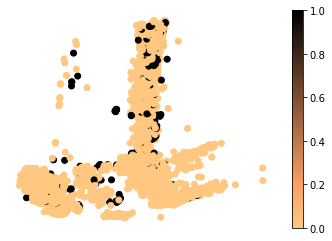

In [33]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_scaled = scaler.fit_transform(train)         
PCA_train_x = PCA(2).fit_transform(train_scaled)
plt.scatter(PCA_train_x[:, 0], PCA_train_x[:, 1], c=y_train, cmap="copper_r")
plt.axis('off')
plt.colorbar()
plt.show()

In [91]:
# initialize model
clf = xgb.XGBClassifier(
    nthread=4,
    max_depth=12, 
    missing=-127,
    subsample=0.8,
    n_estimators=2000,
    learning_rate=0.02, 
    colsample_bytree=0.4, 
    eval_metric="auc",
    tree_method="hist" 
)

In [92]:
%%time

# ORIGINAL X AND Y TRAIN train.loc[idxT, cols], y_train[idxT],
    

# train
h = clf.fit(train.loc[idxT, cols], y_train[idxT],
    
    eval_set=[(train.loc[idxV, cols], y_train[idxV])],
    verbose=50,
    early_stopping_rounds=100,
)

# 0.1 increase for missing value impute with mode

[0]	validation_0-auc:0.77849
Will train until validation_0-auc hasn't improved in 100 rounds.
[50]	validation_0-auc:0.88130
[100]	validation_0-auc:0.89809
[150]	validation_0-auc:0.91043
[200]	validation_0-auc:0.91831
[250]	validation_0-auc:0.92249
[300]	validation_0-auc:0.92518
[350]	validation_0-auc:0.92685
[400]	validation_0-auc:0.92712
[450]	validation_0-auc:0.92648
Stopping. Best iteration:
[382]	validation_0-auc:0.92747

Wall time: 29.3 s


In [105]:
xtrain,ytrain,xvalid,yvalid = train.loc[idxT, cols], y_train[idxT],train.loc[idxV, cols], y_train[idxV]

In [46]:
ytrain.value_counts(normalize = True)

0    0.97128
1    0.02872
Name: isFraud, dtype: float64

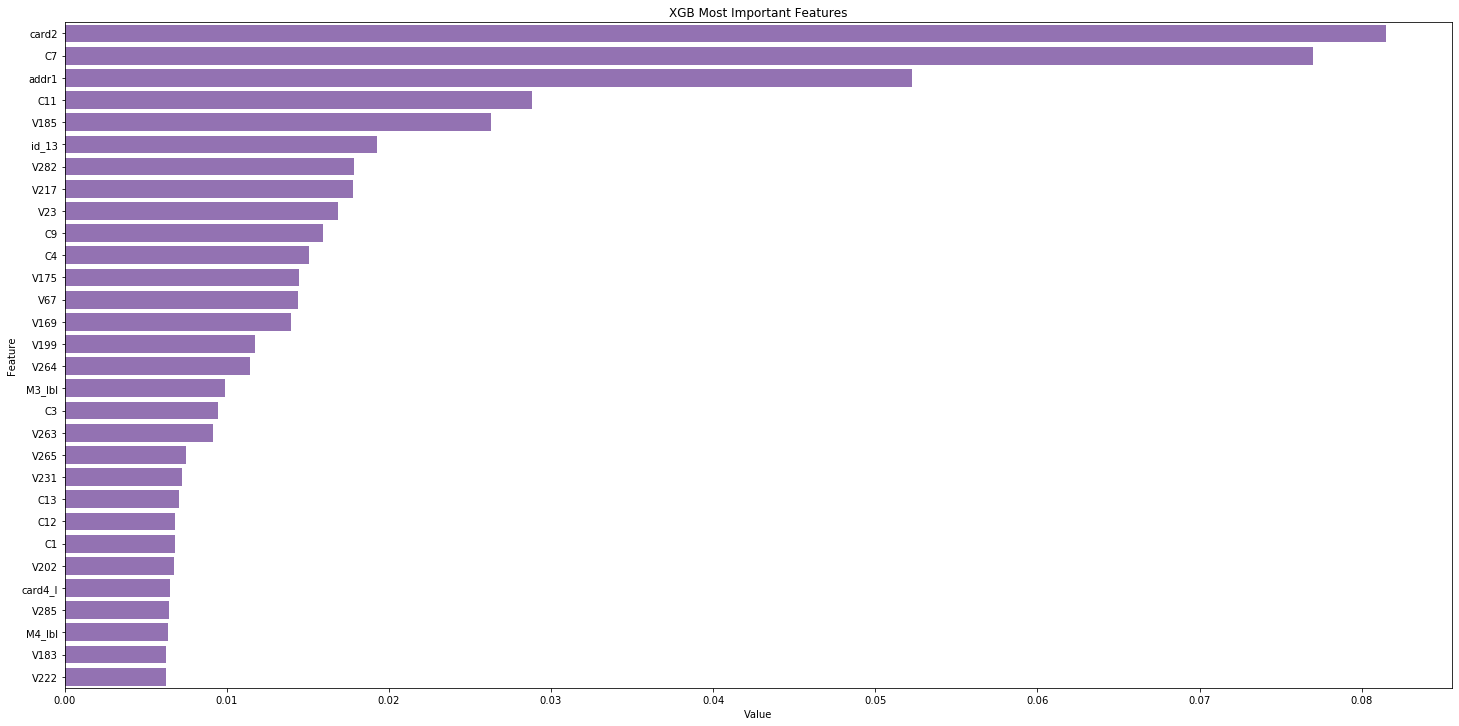

In [113]:
# Feature Importance
plt.figure(figsize=(20, 10))
plt.title('XGB Most Important Features')
plt.tight_layout()

feature_imp = pd.DataFrame(sorted(zip(clf.feature_importances_, train.columns)), columns=["Value", "Feature"])
feature_imp = feature_imp.sort_values(by="Value", ascending=False).iloc[:30]   # first 30 imp features
ax = sns.barplot(x=feature_imp["Value"], y=feature_imp["Feature"].apply(lambda x: str(x)[:7]), color="tab:purple")

del feature_imp

## <span style="color:teal">Prediction</span>

Prediction is done using the previously trained model

In [152]:
prediction = clf.predict(test[cols])

In [153]:
type(prediction)

numpy.ndarray

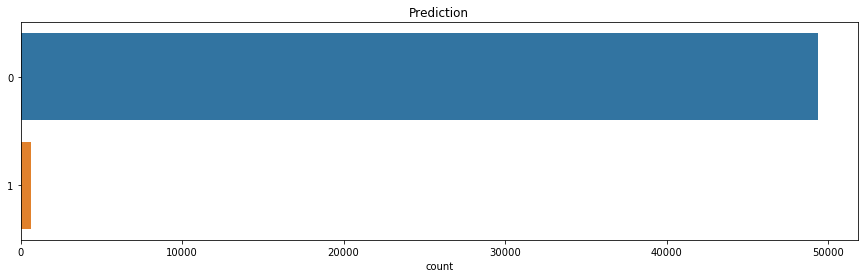

In [116]:
plt.figure(figsize=(15, 4))
plt.title("Prediction")

ax = sns.countplot(y=prediction)

## RESULTS

1.) WITH FE only 'TransactionCents' , only labelencoding, normalizing D columns we and for XGBoost 

nthread=4,
    max_depth=12, 
    missing=-127, 
    subsample=0.8,
    n_estimators=5000,
    learning_rate=0.02, 
    colsample_bytree=0.4, 
    eval_metric="auc",
    tree_method="hist" 
    
we have a roc score of 93.1 % on validation set


2.)With random under sampling accuracy reduced to 91.046

3.)TomekLinks improved accuracy very slightly

##### THE 2 MAIN PROBLEMS WERE : 1) IMBALANCED DATA  2) HUGE NUMBER OF COLUMNS

WE HAVE REDUCED MEMORY USAGE, MISSING VALUE THRESHOLD DROPPING, LOW VARIANCE DROPPING AND HIGH CORRELATION DROP 

NEXT FOR IMBALANCED DATA WE HAVE TRIED XGBOOST ALGORITHM WHICH IS AN ALL IN ONE ALGO WHICH TAKES CARE OF IMABALANCE AS WELL MISSING VALUES AS WELL.

A) OUR NEXT APPROACH WILL BE TO USE FURTHER SOME SAMPLING TECHNIQUES LIKE 'SMOTE' AND USE NEURAL NETWORKS ALONG WITH OTHER ANOMALY DETECTION ALGORITHM 

B) WE CAN ALSO TRY PERFORMING A PCA OF THE TRAIN AND TEST DATA AND FIT IN ORDER TO COMPRESS THE DATA WITHOUT MUCH LOSS OF INFORMATION.





##### Creative feature engineering required and selection/ grouping of features that may take large values or give better indication

##### RESAMPLING TECHNIQUES

For example, we can cluster the records of the majority class, and do the under-sampling by removing records from each cluster, thus seeking to preserve information. In over-sampling, instead of creating exact copies of the minority class records, we can introduce small variations into those copies, creating more diverse synthetic samples.

Let's apply some of these resampling techniques, using the Python library imbalanced-learn. It is compatible with scikit-learn and is part of scikit-learn-contrib projects.




# ISOLATION FOREST

In [148]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import f1_score

In [162]:
IForest = IsolationForest(n_estimators = 100,max_samples = len(xtrain),contamination=0.005,verbose = 0)

In [163]:
IForest.fit(xtrain)

IsolationForest(behaviour='deprecated', bootstrap=False, contamination=0.005,
                max_features=1.0, max_samples=37500, n_estimators=100,
                n_jobs=None, random_state=None, verbose=0, warm_start=False)

In [164]:
prediction = IForest.predict(xvalid)

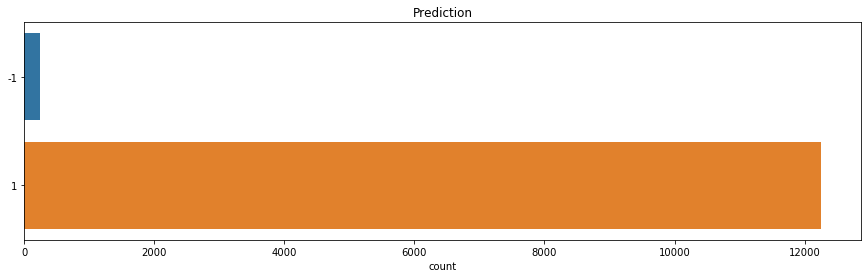

In [165]:
plt.figure(figsize=(15, 4))
plt.title("Prediction")

ax = sns.countplot(y=prediction)

In [166]:
prediction = pd.DataFrame(prediction,columns = ['Label'])

In [167]:
prediction['Label'].replace([1,-1],[0,1],inplace=True)

In [168]:
prediction = prediction['Label'].to_numpy()

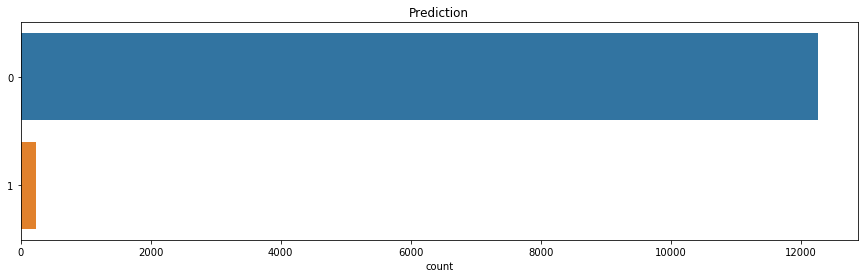

In [169]:
plt.figure(figsize=(15, 4))
plt.title("Prediction")

ax = sns.countplot(y=prediction)

In [151]:
from sklearn.metrics import plot_roc_curve

random_disp = plot_roc_curve(IForest,train.loc[idxV, cols], y_train[idxV])
plt.show()

ValueError: IsolationForest should be a binary classifer